In [1]:
# packages
import numpy as np
import tensorflow
import scipy.ndimage
import tifffile 
import os
import matplotlib.pyplot as plt
import PIL
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython.display import clear_output
% matplotlib inline 

In [2]:
# constants
image_width = 40000
# It will separate the original image in 6400 images 500 x 500 
separate_width = 500 
length_classification = 20
total_images =  image_width / separate_width

# custom flags
show_image = False
cut_and_save_images = False

# custom path and coordinate
data_path = "C:/Users/IBM_ADMIN/workspace/pfc"
coordinates = {"lat": "20S", "lon": "070W"}
dir_name = coordinates["lat"] + coordinates["lon"]

# file paths
tree_cover_path = "{0}/Hansen_GFC2015_treecover2000_{1}_{2}.tif".\
    format(data_path, coordinates["lat"], coordinates["lon"])
first_path = "{0}/Hansen_GFC2015_first_{1}_{2}.tif".\
    format(data_path, coordinates["lat"], coordinates["lon"])
last_path = "{0}/Hansen_GFC2015_last_{1}_{2}.tif".\
    format(data_path, coordinates["lat"], coordinates["lon"])
loss_path = "{0}/Hansen_GFC2015_path_{1}_{2}.tif".\
    format(data_path, coordinates["lat"], coordinates["lon"])

In [3]:
def cut_and_save(directory, name, matrix, length):
    try:
        os.makedirs("{0}/numpy_files/".\
                    format(data_path))
    except FileExistsError:
        pass 
    try:
        os.makedirs("{0}/numpy_files/{1}".\
                    format(data_path, directory))
    except FileExistsError:
        pass
    
    limit = int(len(matrix) / length)
    for i in range(limit):
        for j in range(limit):
            sub_matrix = matrix[i * length : i * length + length,
                                j * length : j * length + length]
            np.save("{0}/numpy_files/{1}/{2}-{3}-{4}.npy".\
                    format(data_path, directory, name, i, j),
                        sub_matrix)

In [4]:
def separate_matrix(matrix, length):
    list_matrix = list()
    limit = int(len(matrix) / length)
    for i in range(limit):
        for j in range(limit):
            sub_matrix = matrix[i * length : i * length + length,
                                j * length : j * length + length]
            list_matrix.append(sub_matrix)
    return list_matrix

In [5]:
def open_images(directory, name, total, length,
                percent=[0,100], label=False):
    list_matrix = list()
    limit_min = int(total * percent[0] * 1.0 / 100)
    limit_max = int(total * percent[1] * 1.0 / 100)
    for i in range(limit_min, limit_max):
        for j in range(total):
            sub_matrix = \
                np.load("{0}/numpy_files/{1}/{2}-{3}-{4}.npy".\
                        format(data_path, directory, name, i, j))
            if not label:
                list_matrix += separate_matrix(sub_matrix, length)
            else:
                separate_current_list = \
                    separate_matrix(sub_matrix, length)
                list_matrix.\
                    append([int((np.mean(current_matrix) + 1) / 10)\
                                    for current_matrix \
                                        in separate_current_list])
    return np.array(list_matrix)


def return_feature(directory, name, length, i, j):
    list_features = list()
    sub_matrix = np.load("{0}/numpy_files/{1}/{2}-{3}-{4}.npy".\
                         format(data_path, directory, name, i, j))
    limit = int(len(sub_matrix) / length)
    for u in range(limit):
        for v in range(limit):
            sub_matrix_current =\
                sub_matrix[u * length : u * length + length,
                           v * length : v * length + length]
            mean_colors = sub_matrix_current.mean(0).mean(0)
            var_colors = sub_matrix_current.var(0).var(0)
            list_features.append(mean_colors.tolist() 
                                 + var_colors.tolist())
    return list_features
            
    
def open_features(directory, name, total, length):
    list_features = list()
    for i in range(total):
        for j in range(total):
            list_features += return_feature(directory,
                                            name, length, i, j)
    return list_features


def classification_criteria(directory, name, length, i, j):
    list_classification = list()
    sub_matrix = np.load("{0}/numpy_files/{1}/{2}-{3}-{4}.npy".\
                         format(data_path, directory, name, i, j))
    limit = int(len(sub_matrix) / length)
    for u in range(limit):
        for v in range(limit):
            sub_matrix_current = \
                sub_matrix[u * length : u * length + length,
                           v * length : v * length + length]
            list_classification.\
                append(int((np.mean(sub_matrix_current) + 1) / 10))               
    return list_classification
    
    
def open_classifications(directory, name, total, length):
    list_classification = list()
    for i in range(total):
        for j in range(total):
            list_classification += \
                classification_criteria(directory,\
                                        name, length, i, j)
    return list_classification

In [6]:
# open, cut and save the first image: 
if cut_and_save_images:
    first_image = tifffile.imread(first_path)
    cut_and_save(dir_name, "first", first_image, separate_width)
    first_image = np.NaN # release memory

In [7]:
# open, cut and save the tree cover: 
if cut_and_save_images:
    treee_cover_image = tifffile.imread(tree_cover_path)
    cut_and_save(dir_name, "treecover",
                 treee_cover_image, separate_width)
    treee_cover_image = np.NaN # release memory

In [8]:
features_example = return_feature(dir_name, "first",
                                  length_classification, 20, 20)
print(("Features:\n-----------------\nMean 1 = {0}\n" +
      "Mean 2 = {1}\nMean 3 = {2}\nMean 4 = {3}").\
      format(features_example[0][0], features_example[0][1],
             features_example[0][2], features_example[0][3]))

Features:
-----------------
Mean 1 = 151.6625
Mean 2 = 93.99999999999999
Mean 3 = 166.3075
Mean 4 = 179.14999999999998


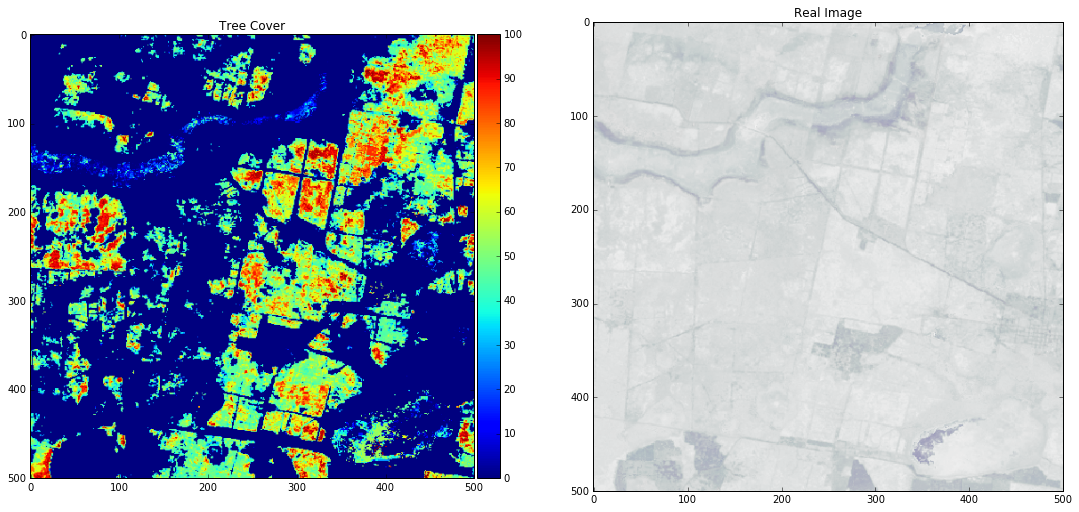

In [9]:
# tree cover anotation in cell (40, 40)
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18.5, 10.5)

tree_cover_example = np.load(("{0}/numpy_files/{1}/" +
                             "{2}-{3}-{4}.npy").\
                             format(data_path, dir_name,
                                    "treecover", 76, 76))
im1 = ax1.imshow(PIL.Image.fromarray(tree_cover_example))
divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
cbar1 = plt.colorbar(im1, cax=cax1)
ax1.set_title("Tree Cover")

# image cell (40, 40)
image_example = np.load("{0}/numpy_files/{1}/{2}-{3}-{4}.npy".\
                        format(data_path, dir_name, "first", 76, 76))
w, h, d = image_example.shape
pil_image = PIL.Image.frombytes("RGBA", (w, h),
                                image_example.tostring())

im2 = ax2.imshow(pil_image)
ax2.set_title("Real Image")

In [10]:
# get features from all sub-images
all_features = open_features(dir_name, "first",
                             int(total_images),
                             length_classification)

# get the labels from all sub-images
all_labels = open_classifications(dir_name,
                                  "treecover", 
                                  int(total_images),
                                  length_classification)

In [11]:
# separating the data in train and test
train_data_x = \
    all_features[0 : int(len(all_features) / 3)]
train_data_y = \
    all_labels[0 : int(len(all_labels) / 3)]
test_data_x = \
    all_features[int(len(all_features) / 3) \
                 : int(len(all_features))]
test_data_y = \
    all_labels[int(len(all_features) / 3)  \
               : int(len(all_labels))]

In [12]:
def success(predicted, result):
    compare = predicted == result
    count_true = 0
    count_false = 0
    for equal in compare:  
        if equal:
            count_true += 1
        else:
            count_false += 1
    return count_true / (count_true + count_false)


def compose_matrix(class_list, image_width,
                   separate_width, length_classification):
    limit = int(image_width / length_classification)
    matrix = list()
    for i in range(limit):
        matrix.append(limit * [-1])
    row_block_length = int(separate_width / length_classification)
    num_block_row = int(image_width / separate_width)
    for i in range(len(class_list)):
        block_num = int(i / (row_block_length * row_block_length))
        u = block_num // num_block_row
        v = block_num % num_block_row
        r = i % (row_block_length * row_block_length)
        x = u * row_block_length + r / (row_block_length)
        y = v * row_block_length + r % (row_block_length)
        matrix[int(x)][int(y)] = class_list[i]
    return matrix

In [13]:
# linear classifier - SGD
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier(loss="hinge", penalty="l2",
                    n_iter=15, n_jobs=1)
clf.fit(train_data_x, train_data_y)
print("Success = {0}".format(success(clf.predict(test_data_x),
                                     test_data_y)))

Success = 0.5815716773035403


In [14]:
# apply classifier in all data
class_list = clf.predict(all_features)
classified_image = compose_matrix(class_list, image_width,
                                  separate_width,
                                  length_classification)

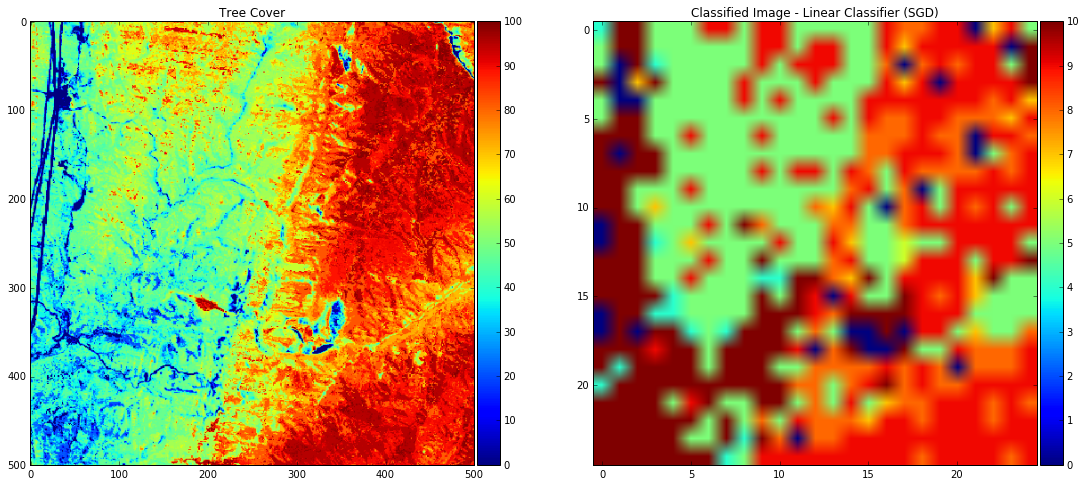

In [15]:
# compare treecover and classfied data
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18.5, 10.5)

tree_cover_example = \
    np.load("{0}/numpy_files/{1}/{2}-{3}-{4}.npy".\
            format(data_path, dir_name, "treecover", 40, 40))
im1 = ax1.imshow(PIL.Image.fromarray(tree_cover_example))
divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
cbar1 = plt.colorbar(im1, cax=cax1)
ax1.set_title("Tree Cover")

# image cell (40, 40)
limit = int(separate_width / length_classification)
class_matrix = list()
for i in range(limit):
    new_row = list()
    for j in range(limit):
        new_row.append(classified_image[40 * limit + i]
                       [40 * limit  + j])
    class_matrix.append(new_row)
im2 = ax2.imshow(class_matrix, vmin=0, vmax=10)
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="5%", pad=0.05)
cbar2 = plt.colorbar(im2, cax=cax2)
ax2.set_title("Classified Image - Linear Classifier (SGD)")

In [16]:
open_labels = True # set True if it is not opened
percent_train_min = 41
percent_train_max = 57
percent_test_min = 53
percent_test_max = 61

# Release Memory
all_features = None
train_data_x = None
train_data_y = None
test_data_x = None
test_data_y = None
class_list = None
classified_image = None
all_images = None
all_labels = None

# Open Images
train_data_x = open_images(dir_name,
                           "first",
                           int(total_images),
                           length_classification,
                           percent=[percent_train_min,
                                    percent_train_max])

test_data_x = open_images(dir_name,
                          "first",
                          int(total_images),
                          length_classification,
                          percent=[percent_test_min,
                                   percent_test_max])

train_data_y = open_images(dir_name,
                           "treecover",
                           int(total_images),
                           length_classification,
                           percent=[percent_train_min,
                                    percent_train_max],
                           label=True)

test_data_y = open_images(dir_name,
                          "treecover",
                          int(total_images),
                          length_classification,
                          percent=[percent_test_min,
                                   percent_test_max],
                          label=True)

In [17]:
''''Trains a simple convnet on the MNIST dataset.
Gets to 99.25% test accuracy after 12 epochs
(there is still a lot of margin for parameter tuning).
16 seconds per epoch on a GRID K520 GPU.
'''
# This is only an example
run_example = False

from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

if run_example:
    batch_size = 128
    num_classes = 10
    epochs = 12

    # input image dimensions
    img_rows, img_cols = 28, 28

    # the data, shuffled and split between train and test sets
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    if K.image_data_format() == 'channels_first':
        x_train = x_train.reshape(x_train.shape[0],
                                  1, img_rows, img_cols)
        x_test = x_test.reshape(x_test.shape[0],
                                1, img_rows, img_cols)
        input_shape = (1, img_rows, img_cols)
    else:
        x_train = x_train.reshape(x_train.shape[0],
                                  img_rows, img_cols, 1)
        x_test = x_test.reshape(x_test.shape[0],
                                img_rows, img_cols, 1)
        input_shape = (img_rows, img_cols, 1)

    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train /= 255
    x_test /= 255
    print('x_train shape:', x_train.shape)
    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')

    # convert class vectors to binary class matrices
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)

    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])

    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data=(x_test, y_test))
    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

Using TensorFlow backend.


In [18]:
batch_size = 32
num_classes = 11
epochs = 1
data_augmentation = True

# The data, shuffled and split between train and test sets:
print('x_train shape:', train_data_x.shape)
print(train_data_x.shape[0], 'train samples')
print(train_data_x.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
train_data_y = keras.utils.\
    to_categorical(train_data_y, num_classes)
test_data_y = keras.utils.\
    to_categorical(test_data_y, num_classes)

model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=train_data_x.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, train_data_y,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(train_data_x, test_data_y),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False, 
        samplewise_center=False,  
        featurewise_std_normalization=False,
        samplewise_std_normalization=False, 
        zca_whitening=False,
        rotation_range=0, 
        width_shift_range=0.1, 
        height_shift_range=0.1,
        horizontal_flip=True,  
        vertical_flip=False) 

    # Compute quantities required for feature-wise normalization
    datagen.fit(train_data_x)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator\
        (datagen.flow(train_data_x, train_data_y,
                      batch_size=batch_size),
         steps_per_epoch=train_data_x.shape[0] // batch_size,
         epochs=epochs,
         validation_data=(test_data_x, test_data_y))
clear_output()

In [19]:
score = model.evaluate(test_data_x, test_data_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.714100446508
Test accuracy: 0.71621


In [20]:
def get_class_from_list(list_class):
    index = -1
    max_prob = -1
    for i in range(len(list_class)):
        if list_class[i] > max_prob:
            index = i
            max_prob = list_class[i]
    return index

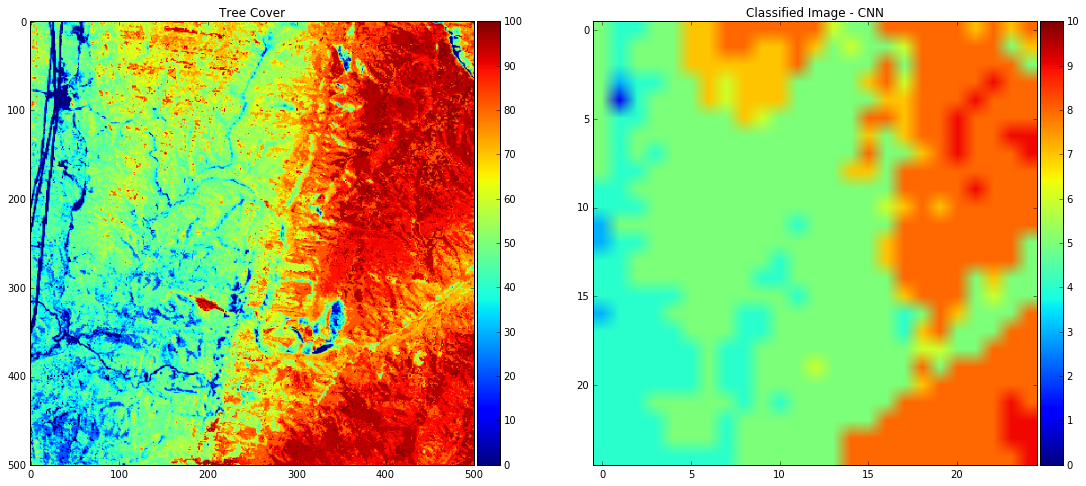

In [21]:
# compare treecover and classfied data
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18.5, 10.5)

tree_cover_example = \
    np.load("{0}/numpy_files/{1}/{2}-{3}-{4}.npy".\
            format(data_path, dir_name, "treecover", 40, 40))
im1 = ax1.imshow(PIL.Image.fromarray(tree_cover_example))
divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
cbar1 = plt.colorbar(im1, cax=cax1)
ax1.set_title("Tree Cover")

limit = int(separate_width / length_classification)
image_cell = \
    np.load("{0}/numpy_files/{1}/{2}-{3}-{4}.npy".\
            format(data_path, dir_name, "first", 40, 40))
list_images = separate_matrix(image_cell, length_classification)
list_predicted = \
    [get_class_from_list(model.predict(np.array([image]))[0])\
     for image in list_images]
class_matrix = list()
for i in range(limit):
    new_row = list()
    for j in range(limit):
        new_row.append(list_predicted[i * limit + j])
    class_matrix.append(new_row)
im2 = ax2.imshow(class_matrix, vmin=0, vmax=10)
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="5%", pad=0.05)
cbar2 = plt.colorbar(im2, cax=cax2)
ax2.set_title("Classified Image - CNN")

In [22]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 20, 20, 32)        1184      
_________________________________________________________________
activation_1 (Activation)    (None, 20, 20, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 18, 18, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 18, 18, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 9, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 9, 9, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 9, 9, 64)          18496     
__________